In [3]:
import pandas as pd
import numpy as np
import re
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking
from tensorflow.keras.utils import to_categorical
from sentence_transformers import SentenceTransformer
from transformers import BertTokenizer, TFBertModel
from sklearn.svm import SVC
import warnings
warnings.filterwarnings("ignore")

In [4]:
from transformers import BertTokenizer, BertModel
import torch

In [5]:
df = pd.read_csv('/kaggle/input/sentiment-analysis-for-mental-health/Combined Data.csv', index_col=0)

In [6]:
df.head()

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


In [7]:
df.describe()

,statement,status
count,52681,53043
unique,51073,7
top,what do you mean?,Normal
freq,22,16351


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53043 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52681 non-null  object
 1   status     53043 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [9]:
df.isna().sum()

statement    362
status         0
dtype: int64

In [10]:
df.dropna(inplace = True)
df.isna().sum()

statement    0
status       0
dtype: int64

In [11]:
df.status.value_counts()

status
Normal                  16343
Depression              15404
Suicidal                10652
Anxiety                  3841
Bipolar                  2777
Stress                   2587
Personality disorder     1077
Name: count, dtype: int64

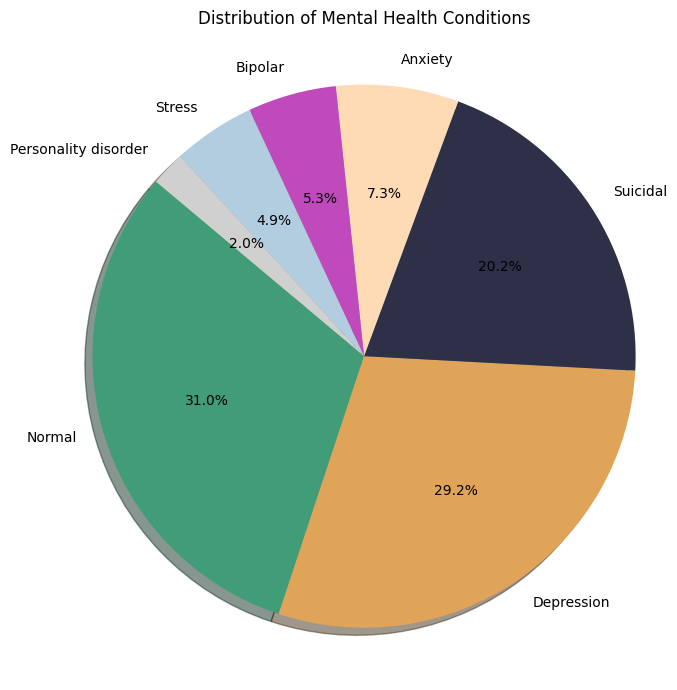

In [12]:
status_counts = df['status'].value_counts()

colors = ['#419D78', '#E0A458', '#2D3047', '#FFDBB5', '#C04ABC', '#B3CDE0', '#D0D0D0']

plt.figure(figsize=(7, 7))
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', 
        startangle=140, colors=colors, shadow=True)

plt.title('Distribution of Mental Health Conditions')
plt.axis('equal') 

plt.tight_layout()
plt.show()

<div style="padding: 20px; border-color: #419D78; border-radius: 10px; box-shadow: 0 2px 4px 0 rgba(0, 0, 0, 0.1); border: 2px solid #419D78;">
    <ul style="font-size: 18px; font-family: 'Arial'; line-height: 1.5em; ">
        The target variable in our dataset is <strong>unbalanced</strong>. This imbalance could affect our model's performance, so we'll need to address it later to ensure accurate and fair predictions.
    </ul>
</div>

In [13]:
random_statements = df.groupby('status')['statement'].apply(lambda x: x.sample(n=1).iloc[0])

for status, statement in random_statements.items():
    print(f"Status: {status}")
    print(f"Statement: {statement}\n")

Status: Anxiety
Statement: Been having very bad nightmares lately. For a time now, I had never had bad dreams, sleep was always quiet and if I had a dream it was always positive. However, lately my dreams has been really bad, it’s always about worst case scenarios where I lose this girl I have been talking to and I feel like I’m developing my feelings towards. Is this anxiety of losing her? How come I never have these thoughts when I’m lucid. P.S. sorry for the bad english I’m not a first hand speaker of english. Thank you!

Status: Bipolar
Statement: needing validation ive never posted on this subreddit before because i am not officially diagnosed bipolar, but i went from MDD to an unspecified mood disorder in less than a year. some bg: im a college sophomore. the first time i ever went to therapy was march of last year. i started lamictal in december. growing up mental illness was just not a thing to my parents, so i never saw any doctor or pdoc.

basically, ive had to do and learn e

In [14]:
df['num_of_characters'] = df['statement'].str.len()
df['num_of_sentences'] = df['statement'].apply(lambda x: len(nltk.sent_tokenize(x)))

description = df[['num_of_characters', 'num_of_sentences']].describe()

print(description)

       num_of_characters  num_of_sentences
count       52681.000000      52681.000000
mean          578.713863          6.277728
std           846.269078         10.686230
min             2.000000          1.000000
25%            80.000000          1.000000
50%           317.000000          3.000000
75%           752.000000          8.000000
max         32759.000000       1260.000000


In [15]:
df[df['num_of_characters'] > 10000]

,statement,status,num_of_characters,num_of_sentences
7851,So introduction I guess.. my name is Michael a...,Depression,10679,136
9416,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,Suicidal,25302,1
9504,"Hello everyone,I rarely post on Reddit but.......",Depression,11163,139
10834,I have only 1 person I can somewhat open to bu...,Suicidal,27390,237
11537,"The title is not meant to discourage others, b...",Depression,12304,155
11581,I no longer know what else to do but write thi...,Depression,13530,140
11636,And has life gotten better?&amp;#x200B;No. Eve...,Depression,12819,96
11831,Sorry this is long but I doubt anyone will eve...,Depression,11122,155
13293,I cannot TAKE IT ANYMORE. I cannot TAKE IT ANY...,Suicidal,32759,1260
18215,I am someone living in Turkey. My age is proba...,Suicidal,10219,180


In [16]:
df.rename(columns={'statement': 'original_statement'}, inplace=True)  

df['statement']=df['original_statement'].str.lower()
df.head()

,original_statement,status,num_of_characters,num_of_sentences,statement
0,oh my gosh,Anxiety,10,1,oh my gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,2,"trouble sleeping, confused mind, restless hear..."
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,2,"all wrong, back off dear, forward doubt. stay ..."
3,I've shifted my focus to something else but I'...,Anxiety,61,1,i've shifted my focus to something else but i'...
4,"I'm restless and restless, it's been a month n...",Anxiety,72,2,"i'm restless and restless, it's been a month n..."


## 3.2. Removing URLs, handles, punctuation and special characters

To remove specific patterns such as URLs or other unwanted text (like ```[View Poll](https://www.reddit.com/poll/...)```) from a column in a pandas DataFrame, we can use regular expressions with the re module or pandas built-in string methods.

In [17]:
def remove_patterns(text):
    # Remove URLs
    text = re.sub(r'http[s]?://\S+', '', text)
    # Remove markdown-style links
    text = re.sub(r'\[.*?\]\(.*?\)', '', text)
    # Remove handles (that start with '@')
    text = re.sub(r'@\w+', '', text)
    # Remove punctuation and other special characters
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip()

# Apply the function to the 'statement' column
df['statement'] = df['statement'].apply(remove_patterns)
df.head()

,original_statement,status,num_of_characters,num_of_sentences,statement
0,oh my gosh,Anxiety,10,1,oh my gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,2,trouble sleeping confused mind restless heart ...
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,2,all wrong back off dear forward doubt stay in ...
3,I've shifted my focus to something else but I'...,Anxiety,61,1,ive shifted my focus to something else but im ...
4,"I'm restless and restless, it's been a month n...",Anxiety,72,2,im restless and restless its been a month now ...


## 3.3. Tokenization

Split text into individual words or tokens.

In [18]:
df['tokens'] = df['statement'].apply(word_tokenize)
df.head()


,original_statement,status,num_of_characters,num_of_sentences,statement,tokens
0,oh my gosh,Anxiety,10,1,oh my gosh,"[oh, my, gosh]"
1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,2,trouble sleeping confused mind restless heart ...,"[trouble, sleeping, confused, mind, restless, ..."
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,2,all wrong back off dear forward doubt stay in ...,"[all, wrong, back, off, dear, forward, doubt, ..."
3,I've shifted my focus to something else but I'...,Anxiety,61,1,ive shifted my focus to something else but im ...,"[ive, shifted, my, focus, to, something, else,..."
4,"I'm restless and restless, it's been a month n...",Anxiety,72,2,im restless and restless its been a month now ...,"[im, restless, and, restless, its, been, a, mo..."


## 3.4. Stemming

Reduce words to their base or root form. However, in some cases, the stemming process produces words that are not correct spellings of the root word. For example, **happi** and **sunni**. That's because it chooses the most common stem for related words. For example, we can look at the set of words that comprises the different forms of happy:

- happy
- happiness
- happier

We can see that the prefix **happi** is more commonly used. We cannot choose **happ** because it is the stem of unrelated words like **happen**.

In [19]:
stemmer = PorterStemmer()
df['tokens_stemmed'] = df['tokens'].apply(lambda x: ' '.join(stemmer.stem(word) for word in x))


## 3.5. Stop Words

While stop words are typically removed to reduce noise, in sentiment analysis for mental health, many stop words are actually crucial for understanding context and sentiment. Words like negations and those related to emotions (e.g., 'how', 'why', 'because') provide important insights. Removing these can decrease the accuracy of the analysis.

##  3.6. Word Clouds

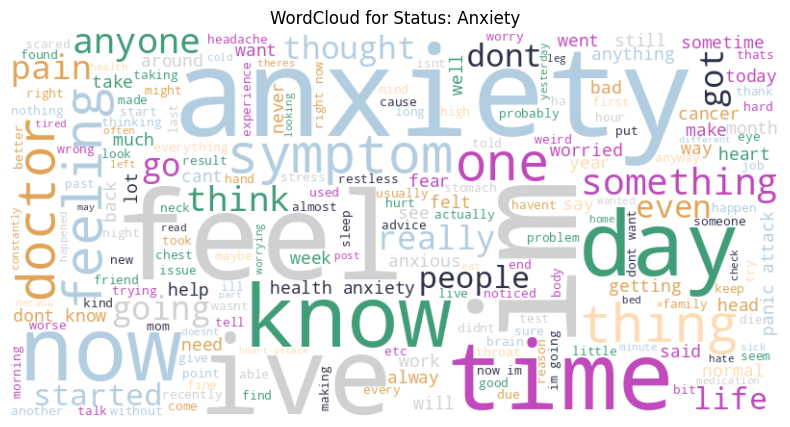

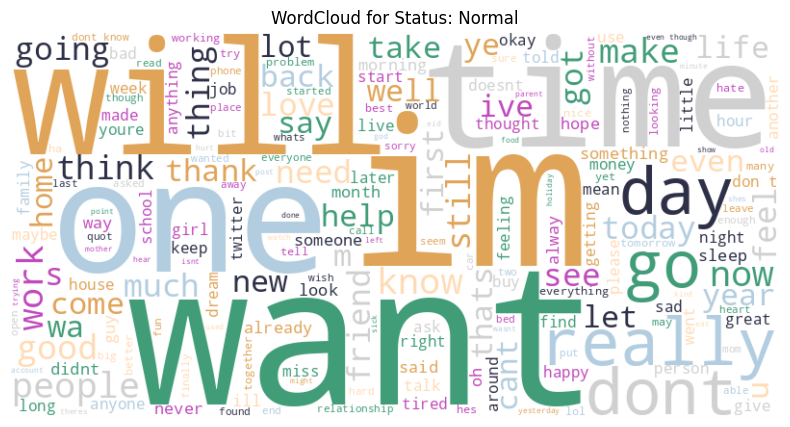

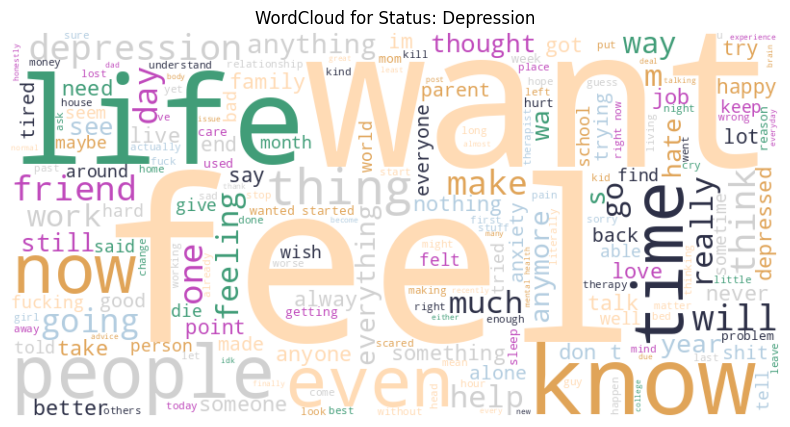

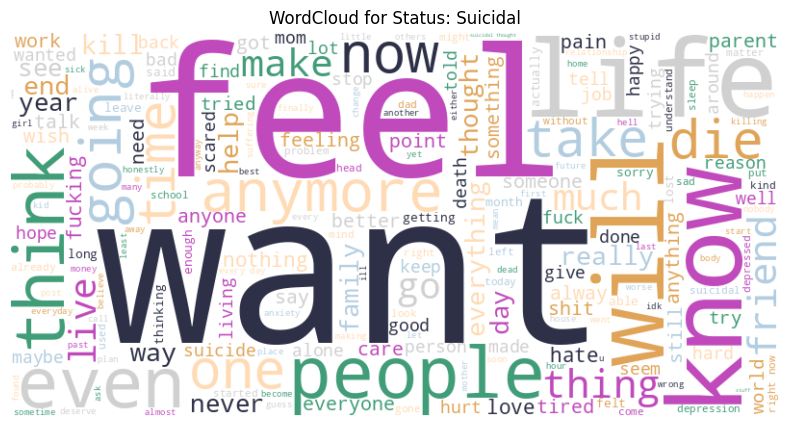

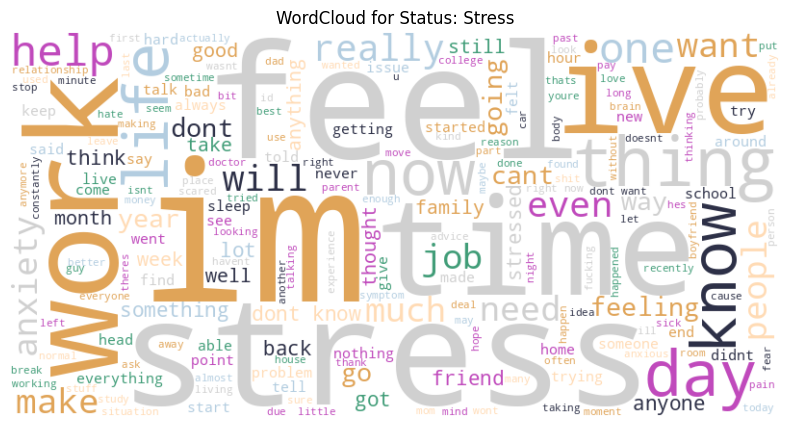

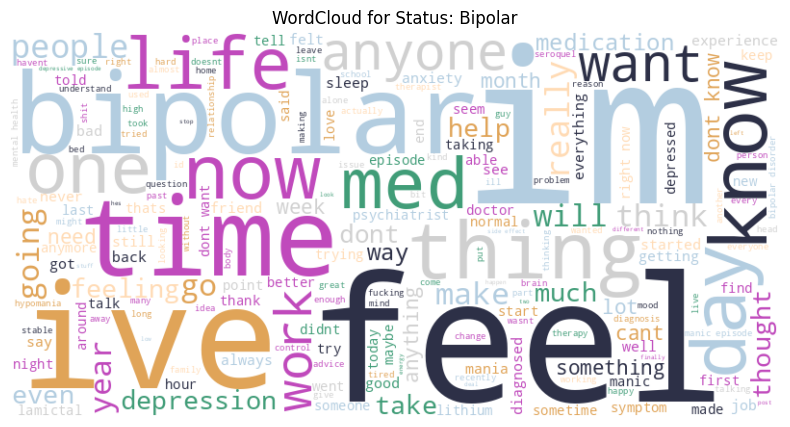

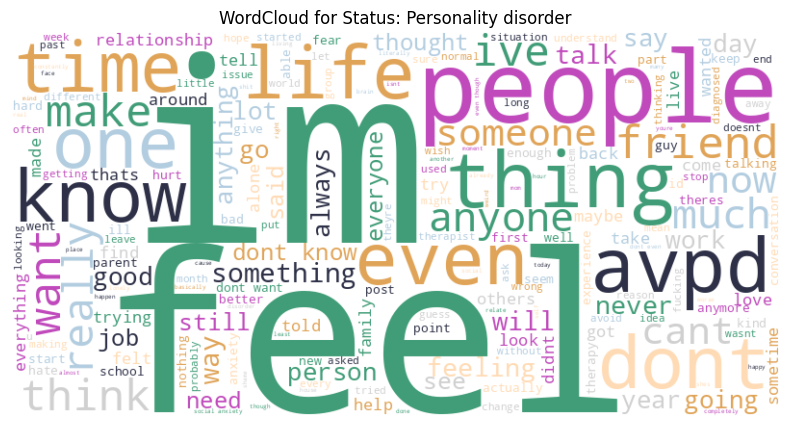

In [20]:
from wordcloud import WordCloud
import random
# Get unique categories in 'status'
statuses = df['status'].unique()

# Define a color function
def color_func(word, font_size, position, orientation, random_state=101, **kwargs):
    return random.choice(colors)

# Generate and plot the WordCloud for each category
for status in statuses:
    # Filter the tokens data for the current status
    tokens_data = ' '.join(df[df['status'] == status]['tokens'].dropna().apply(lambda x: ' '.join(x)).tolist())

    # Generate the WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=color_func).generate(tokens_data)
    
    # Plot the WordCloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Turn off axis
    plt.title(f'WordCloud for Status: {status}')
    plt.show()


<div style="padding: 20px; border-color: #419D78; border-radius: 10px; box-shadow: 0 2px 4px 0 rgba(0, 0, 0, 0.1); border: 2px solid #419D78;">
    <ul style="font-size: 18px; font-family: 'Arial'; line-height: 1.5em; ">
        There is a significant overlap in the language used for discussing depression and suicidal thoughts in our data. Many terms and phrases are used interchangeably or similarly for both conditions, which may complicate the distinction between them. 
    </ul>
</div>

<a id="datapreprocessing"></a>
# <div style="text-align:center; border-radius:30px 30px; padding:9px; color:white; margin:0; font-size:110%; font-family:Arial; background-color:#419D78; overflow:hidden"><b> 4. Data Preprocessing </b></div>

## 4.1. Separate features and labels

In [21]:
lbl_enc = LabelEncoder()
y = lbl_enc.fit_transform(df['status'].values)

## 4.2. Label encoding target variable

In [22]:
X_train_text, X_test_text, y_train, y_test = train_test_split(df['statement'], y, test_size=0.2, random_state=101)



TF-IDF + RF Results
Accuracy: 0.6868178798519503
                      precision    recall  f1-score   support

             Anxiety       0.79      0.50      0.61       768
             Bipolar       0.91      0.53      0.67       566
          Depression       0.57      0.79      0.66      3050
              Normal       0.75      0.95      0.84      3237
Personality disorder       1.00      0.30      0.46       202
              Stress       0.90      0.18      0.31       530
            Suicidal       0.74      0.42      0.54      2184

            accuracy                           0.69     10537
           macro avg       0.81      0.53      0.58     10537
        weighted avg       0.72      0.69      0.67     10537



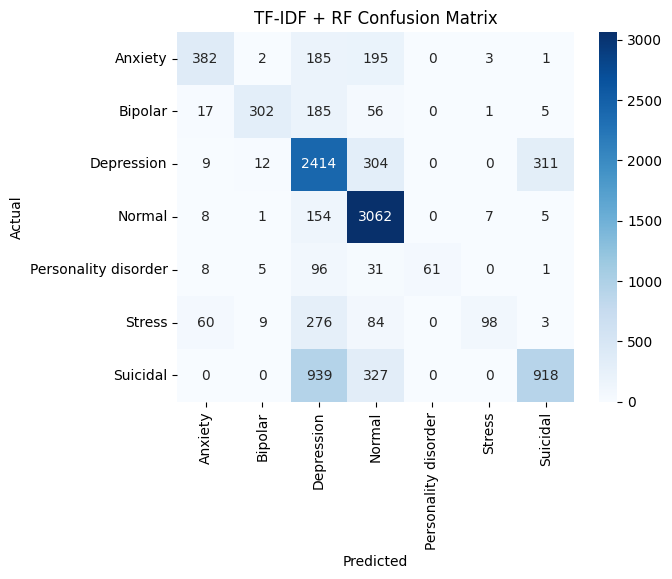

In [23]:
tfidf = TfidfVectorizer(max_features=2000)
X_train_tfidf = tfidf.fit_transform(X_train_text).toarray()
X_test_tfidf = tfidf.transform(X_test_text).toarray()

rf_tfidf = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42)
rf_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf = rf_tfidf.predict(X_test_tfidf)

print("\nTF-IDF + RF Results")
print("Accuracy:", accuracy_score(y_test, y_pred_tfidf))
print(classification_report(y_test, y_pred_tfidf, target_names=lbl_enc.classes_))

sns.heatmap(confusion_matrix(y_test, y_pred_tfidf), annot=True, fmt='d', cmap='Blues', xticklabels=lbl_enc.classes_, yticklabels=lbl_enc.classes_)
plt.title('TF-IDF + RF Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [28]:
user_input = input("\nEnter a sentence to classify: ")
user_input_cleaned = remove_patterns(user_input.lower())

user_tfidf_vec = tfidf.transform([user_input_cleaned]).toarray()
tfidf_pred = rf_tfidf.predict(user_tfidf_vec)[0]
print("TF-IDF Prediction:", lbl_enc.classes_[tfidf_pred])



Enter a sentence to classify:  I have this constant fear of danger. Wherever i am there is this feeling both looming over me and inside me if that makes sense. I have learned to live with the fear, and at times I am grateful for it. Sometimes tho like if I am left alone for a while, it can be so overwhelming i cannot sleep. Suicidal thoughts sometimes feel the same to me. There are times where i wake up and I am half conscious and the thing that is running through my brain in those times is my family crying over my suicide. Lately tho its been getting easier to listen to their cries. i have no clue how to breathe


TF-IDF Prediction: Depression


In [29]:
from gensim.models import Word2Vec


In [30]:
word2vec_model = Word2Vec(sentences=df['tokens'], vector_size=100, window=5, min_count=1, workers=4, sg=1)
word2vec_model.train(df['tokens'], total_examples=len(df['tokens']), epochs=10)


(42287536, 59627220)

In [31]:
def get_avg_w2v(tokens, model, vector_size=100):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(vector_size)



Word2Vec + RF Results
Accuracy: 0.701243238113315
                      precision    recall  f1-score   support

             Anxiety       0.74      0.60      0.66       768
             Bipolar       0.78      0.45      0.57       566
          Depression       0.58      0.73      0.65      3050
              Normal       0.81      0.95      0.87      3237
Personality disorder       1.00      0.28      0.44       202
              Stress       0.82      0.26      0.40       530
            Suicidal       0.68      0.55      0.61      2184

            accuracy                           0.70     10537
           macro avg       0.77      0.54      0.60     10537
        weighted avg       0.71      0.70      0.69     10537



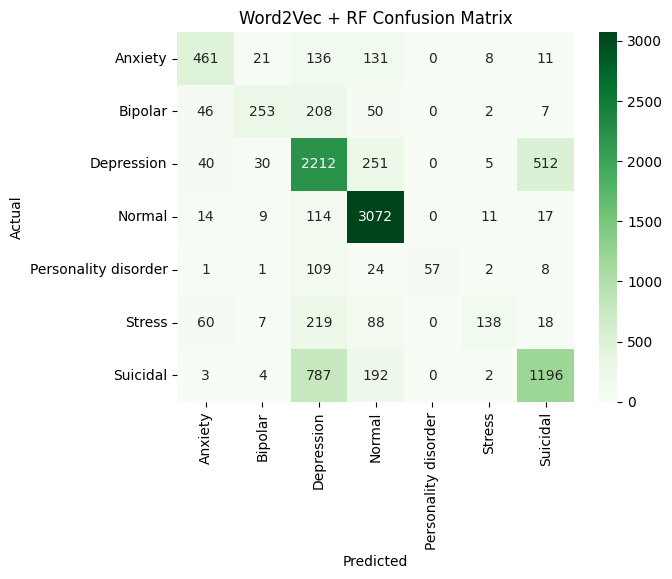

In [32]:
X_train_tok = X_train_text.apply(word_tokenize)
X_test_tok = X_test_text.apply(word_tokenize)

X_train_w2v = np.array([get_avg_w2v(tokens, word2vec_model) for tokens in X_train_tok])
X_test_w2v = np.array([get_avg_w2v(tokens, word2vec_model) for tokens in X_test_tok])

rf_w2v = RandomForestClassifier()
rf_w2v.fit(X_train_w2v, y_train)
y_pred_w2v = rf_w2v.predict(X_test_w2v)

print("\nWord2Vec + RF Results")
print("Accuracy:", accuracy_score(y_test, y_pred_w2v))
print(classification_report(y_test, y_pred_w2v, target_names=lbl_enc.classes_))

sns.heatmap(confusion_matrix(y_test, y_pred_w2v), annot=True, fmt='d', cmap='Greens', xticklabels=lbl_enc.classes_, yticklabels=lbl_enc.classes_)
plt.title('Word2Vec + RF Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [33]:
user_input = input("\nEnter a sentence to classify: ")
user_input_cleaned = remove_patterns(user_input.lower())
user_tokens = word_tokenize(user_input_cleaned)
user_w2v_vec = get_avg_w2v(user_tokens, word2vec_model).reshape(1, -1)
w2v_pred = rf_w2v.predict(user_w2v_vec)[0]
print("Word2Vec Prediction:", lbl_enc.classes_[w2v_pred])



Enter a sentence to classify:  Made a new Reddit account just for this. I was directed here from r/depression. I read through the rules and sidebar and want to make sure I am following everything. So here it is: I have a desire to die that has been growing in the last few months. Thinking I want to die is like a mantra I ruminate on through out my day. I do not have previous attempts, just previous depression and family history of depression. I have ideas of how I would do it, but I am not happy with them. I would want find a way my wife and young kids would get insurance money (seems tricky), and I would want to be found by first responders so that no one I love is traumatized.I have admitted to myself that thoughts are serious enough that I should try to get help. I know intellectually that my wife and kids require my continuing existence for their well-being, despite my feelings I am just a paycheck and a living household appliance. I know there are lots of other reasons to live, e

Word2Vec Prediction: Suicidal


In [ ]:
import torch
from transformers import BertTokenizer, BertModel

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model = bert_model.to(device)

bert king

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

Extracting BERT embeddings (this may take a minute)...

Random Forest Classification Report:
Accuracy: 0.6668866057121312
                      precision    recall  f1-score   support

             Anxiety       0.75      0.37      0.50       779
             Bipolar       0.78      0.34      0.48       580
          Depression       0.55      0.75      0.63      3100
              Normal       0.78      0.96      0.86      3327
Personality disorder       0.62      0.37      0.46       248
              Stress       0.86      0.27      0.42       557
            Suicidal       0.61      0.42      0.50      2018

            accuracy                           0.67     10609
           macro avg       0.71      0.50      0.55     10609
        weighted avg       0.68      0.67      0.65     10609



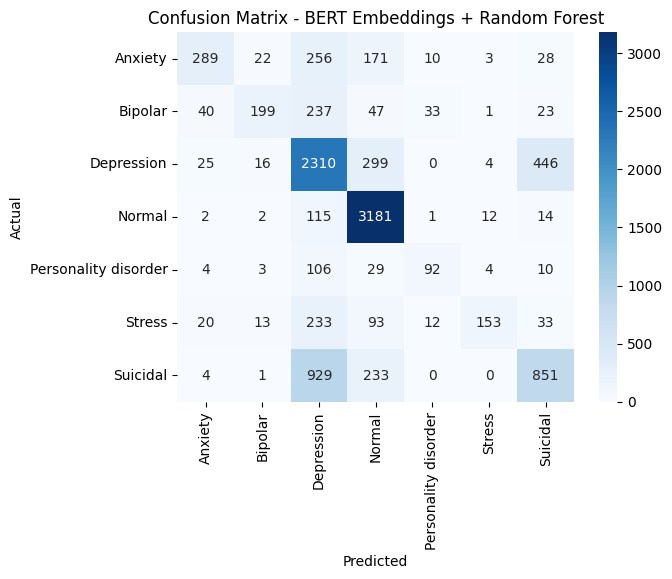

In [34]:
import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and preprocess data
df = pd.read_csv('/kaggle/input/sentiment-analysis-for-mental-health/Combined Data.csv', index_col=0)
df.rename(columns={'statement': 'text'}, inplace=True)
df['text'] = df['text'].fillna('').str.lower()

# Encode labels
lbl_enc = LabelEncoder()
df['label'] = lbl_enc.fit_transform(df['status'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

# Load BERT model (without classification head)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model.to(device)
bert_model.eval()

# Function to get CLS token embedding from BERT
def get_bert_embeddings(texts, tokenizer, model, max_len=128):
    embeddings = []
    with torch.no_grad():
        for text in texts:
            encoded = tokenizer.encode_plus(
                text,
                add_special_tokens=True,
                max_length=max_len,
                padding='max_length',
                truncation=True,
                return_attention_mask=True,
                return_tensors='pt'
            )
            input_ids = encoded['input_ids'].to(device)
            attention_mask = encoded['attention_mask'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            cls_embedding = outputs.last_hidden_state[:, 0, :]  # [CLS] token
            embeddings.append(cls_embedding.cpu().numpy().flatten())
    return np.array(embeddings)

# Extract embeddings
print("Extracting BERT embeddings (this may take a minute)...")
X_train_embeddings = get_bert_embeddings(X_train, tokenizer, bert_model)
X_test_embeddings = get_bert_embeddings(X_test, tokenizer, bert_model)

# Train RandomForest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_embeddings, y_train)

# Predict and evaluate
y_pred = rf.predict(X_test_embeddings)
print("\nRandom Forest Classification Report:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=lbl_enc.classes_))

# Confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=lbl_enc.classes_, yticklabels=lbl_enc.classes_)
plt.title('Confusion Matrix - BERT Embeddings + Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


fdsferfefdeed

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

Training completed for 1 epoch.

Evaluation after 1 Epoch:
Accuracy: 0.8259967951739089
                      precision    recall  f1-score   support

             Anxiety       0.88      0.88      0.88       779
             Bipolar       0.87      0.79      0.83       580
          Depression       0.77      0.79      0.78      3100
              Normal       0.95      0.96      0.96      3327
Personality disorder       0.65      0.74      0.69       248
              Stress       0.74      0.75      0.75       557
            Suicidal       0.71      0.69      0.70      2018

            accuracy                           0.83     10609
           macro avg       0.80      0.80      0.80     10609
        weighted avg       0.83      0.83      0.83     10609



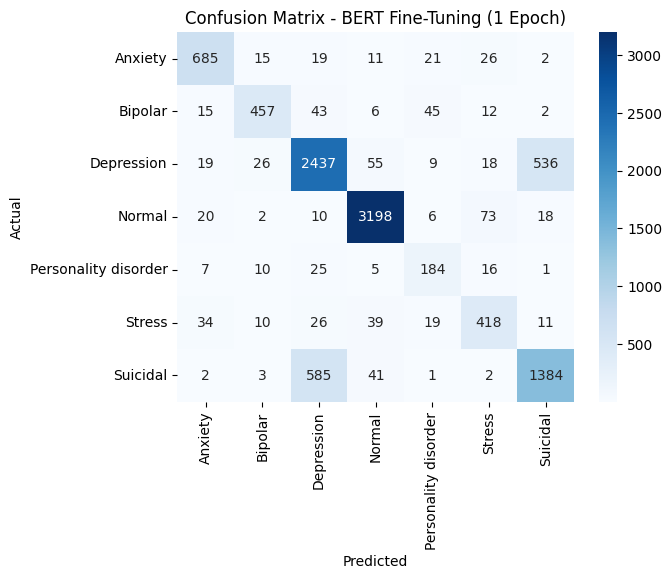

In [35]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and preprocess data
df = pd.read_csv('/kaggle/input/sentiment-analysis-for-mental-health/Combined Data.csv', index_col=0)
df.rename(columns={'statement': 'text'}, inplace=True)
df['text'] = df['text'].fillna('').str.lower()

# Encode labels
lbl_enc = LabelEncoder()
df['label'] = lbl_enc.fit_transform(df['status'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer.encode_plus(
            self.texts.iloc[idx],
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels.iloc[idx], dtype=torch.long)
        }

# Create datasets and loaders
train_dataset = TextDataset(X_train, y_train, tokenizer)
test_dataset = TextDataset(X_test, y_test, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# Load model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(lbl_enc.classes_))
model.to(device)

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Training loop (1 epoch)
model.train()
for batch in train_loader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)

    outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
    loss = outputs.loss
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

print("Training completed for 1 epoch.")

# Evaluation
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Results
print("\nEvaluation after 1 Epoch:")
print("Accuracy:", accuracy_score(true_labels, predictions))
print(classification_report(true_labels, predictions, target_names=lbl_enc.classes_))

sns.heatmap(confusion_matrix(true_labels, predictions), annot=True, fmt='d', cmap='Blues',
            xticklabels=lbl_enc.classes_, yticklabels=lbl_enc.classes_)
plt.title('Confusion Matrix - BERT Fine-Tuning (1 Epoch)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [38]:
# Function to preprocess and tokenize input
def predict_sentiment_bert(text, model, tokenizer, label_encoder, max_len=128):
    model.eval()
    inputs = tokenizer.encode_plus(
        text.lower(),
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        pred = torch.argmax(logits, dim=1).item()

    return label_encoder.classes_[pred]

# Take user input and predict
user_input = input("\nEnter a sentence to classify using BERT: ")
bert_pred = predict_sentiment_bert(user_input, model, tokenizer, lbl_enc)
print("BERT Prediction:", bert_pred)



Enter a sentence to classify using BERT:  Hello guys. I was on meds for my suicidal depression for 6 months. I quit meds 2 months ago. Meds caused loss of libido and morning wood. I measured my hormones and it turns out my prolactin was extremely elevated due to antipsychotic and antidepressant I was on. This can because low libido and loss of morning wood. In the past two weeks my libido finaly started getting better (even close to normal) because I am not on meds, however my morning wood is still scarce. Two days ago, I remembered my psych ward experience and prolactin elevation and I got furious and depressed to the point of not being able to work and do anything.My libido during these 3 days is non-existent. Is this normal? I am not on any meds now (for 2 months now). Is it normal to lose libido in extremely depressive episode?


BERT Prediction: Depression


In [ ]:
# Reset index to align with predictions
X_test_reset = X_test.reset_index(drop=True)

# Convert predictions and true labels to numpy arrays
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Identify misclassified indices
misclassified_indices = np.where(predictions != true_labels)[0]

# Print 5 examples of misclassified data
print("\nExamples of misclassified data:\n")
for idx in misclassified_indices[:5]:
    print(f"Text: {X_test_reset[idx]}")
    print(f"True Label: {lbl_enc.inverse_transform([true_labels[idx]])[0]}")
    print(f"Predicted Label: {lbl_enc.inverse_transform([predictions[idx]])[0]}")
    print("-" * 80)
